# Source code

In [2]:
%load_ext autoreload
%load_ext Cython
%autoreload 2
import numpy as np, h5py, matplotlib.pyplot as plt, pyqtgraph as pg, numba as nb, concurrent.futures, cv2, os
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.ndimage.measurements import label, maximum_position
from scipy import constants
from multiprocessing import cpu_count
from functools import partial
from itertools import accumulate
from math import cos, sin, sqrt, pi, atan2
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from skimage.transform import probabilistic_hough_line
from skimage.draw import line_aa
from cbc_dp.utils import mask as maskdict, zero as zerodict
from cbc_dp.Qt import VolumeViewer, ScatterViewer, makeApp, volumedata
from cbc_dp import CorrectedData, LineSegmentDetector, HoughLineDetector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
class ROI(object):
    def __init__(self, roi):
        self.roi = roi
        
    @property
    def index(self): return (slice(self.roi[0], self.roi[1]), slice(self.roi[2], self.roi[3]))
    
    def mask(self, shape):
        mask = np.zeros(shape, dtype=np.uint8)
        mask[self.index] = 1
        return mask
    
    def __getitem__(self, index): return self.roi[index]
    
def loadlines(file):
    idxs = list(file[linespath])
    idxs.sort()
    return [file[linespath][idx][:] for idx in idxs]

def loadintensities(file):
    idxs = list(file[intspath])
    idxs.sort()
    return [file[intspath][idx][:] for idx in idxs]

In [11]:
peakspath = "exp_results/scan_{0:05}/scan_peaks_{0:05}.h5"
corpath = "exp_results/scan_{0:05}/scan_corrected_{0:05}.h5"
cordatapath = 'corrected_data/data'
bgdpath = 'corrected_data/background'
cordatapath = 'corrected_data/corrected_data'
strkspath = 'corrected_data/streaks_data'
datapath = 'data/data'
linespath = 'peaks_data/bragg_lines'
intspath = 'peaks_data/bragg_intensities'
pupilroi = ROI(np.array([1070, 1250, 1250, 1600]))
lysroi = ROI(np.array([500, 1767, 800, 2070]))
b12roi = ROI(np.array([700, 2167, 600, 2070]))
fullroi = ROI(np.array([0, 2167, 0, 2070]))
detdist = {135: 182.7, 107:150.0}
pixsize = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3

In [13]:
f135 = h5py.File(corpath.format(135), 'r')
b12data = f135[cordatapath][:]
b12bgd = f135[bgdpath][:]
b12strks = f135[strkspath][:]

In [14]:
f107 = h5py.File(corpath.format(107), 'r')
lysdata = f107[cordatapath][:]
lysbgd = f107[bgdpath][:]
lysstrks = f107[strkspath][:]

# Data processing

In [9]:
image = b12data[0]
strks = np.where(image - b12bgd[0] > 30, image, 0)
strks2 = median_filter(strks, (3,3))
strks3 = np.clip(strks2, 0, 150)
nms1 = nms(strks2.astype(np.float64))
gray = cv2.cvtColor(np.tile((strks3 / strks3.max() * 255).astype(np.uint8)[..., np.newaxis], (1,1,3)), cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(np.tile((strks4 / strks4.max() * 255).astype(np.uint8)[..., np.newaxis], (1,1,3)), cv2.COLOR_BGR2GRAY)

NameError: name 'nms' is not defined

In [53]:
lnslist = []
lnslist.append(framelines(strks2, zerodict[135], 15, 15, 3, 10, 5))
lnslist.append(framelines(nms1, zerodict[135], 15, 15, 3, 10, 5))
lnslist.append(cv2.createLineSegmentDetector(_sigma_scale=0.2, _scale=0.5).detect(gray)[0][:, 0].reshape((-1, 2, 2)))
lnslist.append(LSDlines(lnslist[2], zerodict[135], 20, 10))
ptslist = [framepoints(image, lns, np.array([1550, 1730])) for lns in lnslist]

In [61]:
np.mean(strks2[strks2 != 0]) + np.std(strks2[strks2 != 0])

143.09627619948168

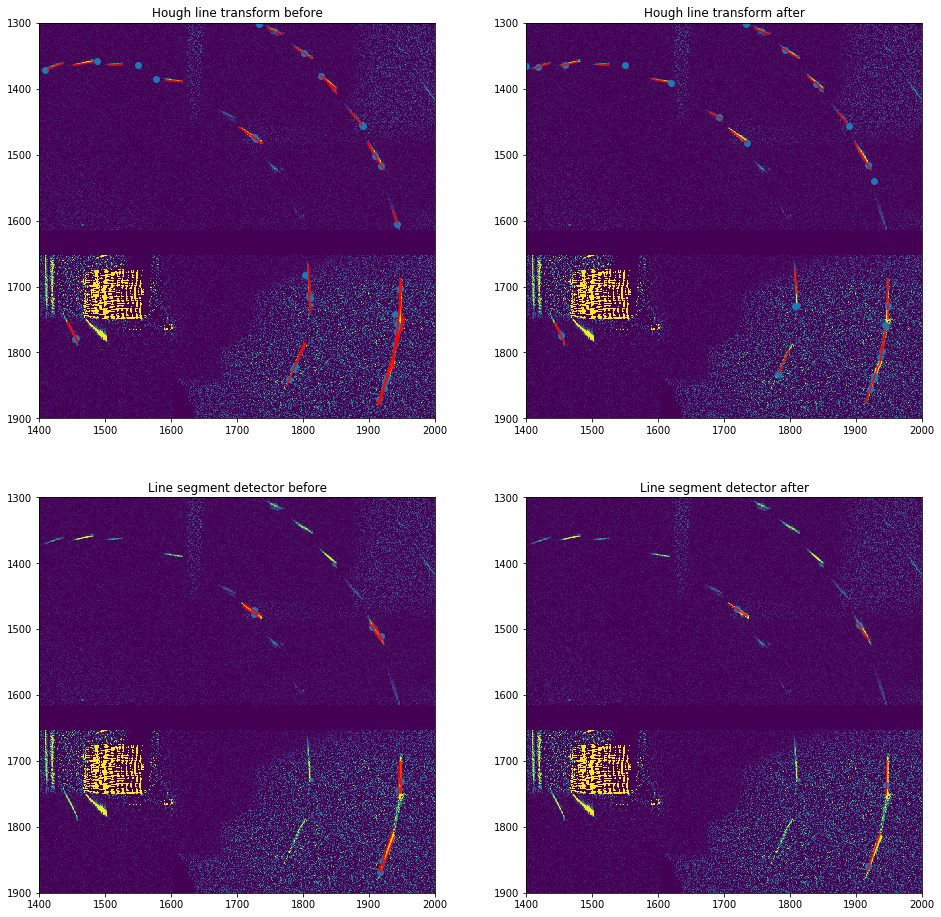

In [54]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
titles = ['Hough line transform before', 'Hough line transform after', 'Line segment detector before', 'Line segment detector after']
for ax, lines, pts, title in zip(axes.ravel(), lnslist, ptslist, titles):
    ax.imshow(image, vmax=200)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'r')  
    ax.scatter(pts[:, 0], pts[:, 1])
    ax.set_xlim(1400, 2000)
    ax.set_ylim(1900, 1300)
    ax.set_title(title)
plt.show()

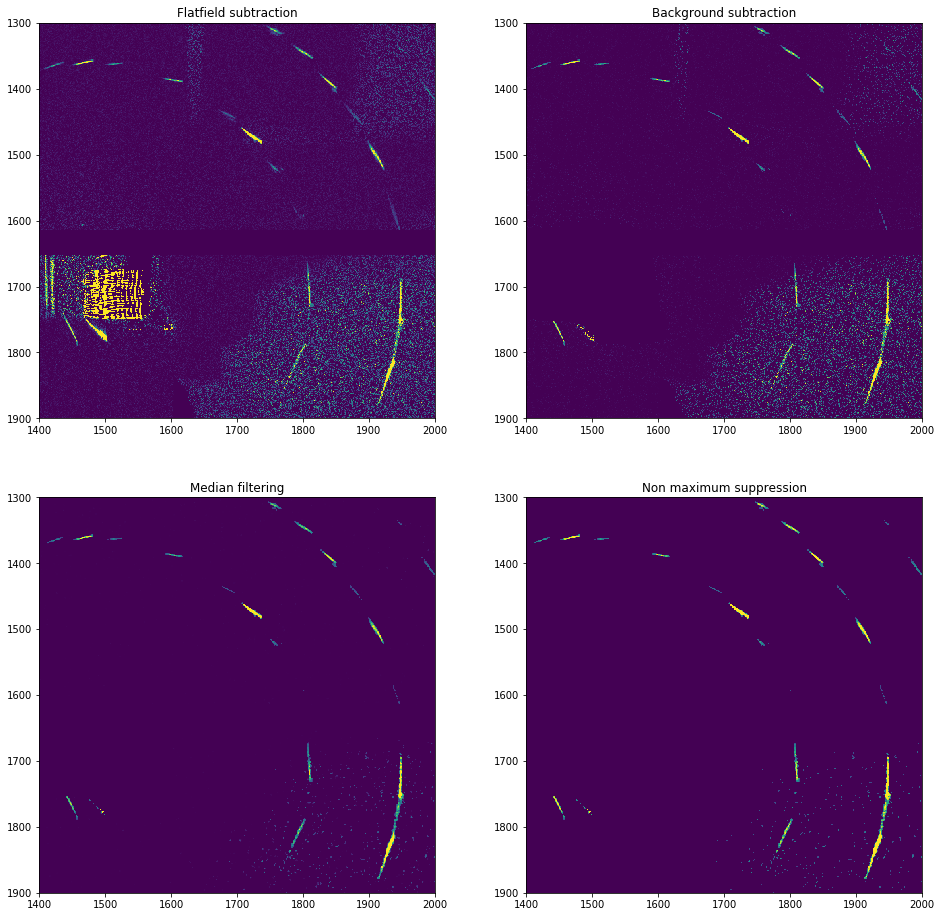

In [123]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0,0].imshow(image, vmax=200)
axes[0,0].set_title('Flatfield subtraction')
axes[0,1].imshow(strks, vmax=200)
axes[0,1].set_title('Background subtraction')
axes[1,0].imshow(strks2, vmax=200)
axes[1,0].set_title('Median filtering')
axes[1,1].imshow(strks3, vmax=150)
axes[1,1].set_title('Non maximum suppression')
for ax in axes.ravel():
    ax.set_xlim(1400, 2000)
    ax.set_ylim(1900, 1300)
plt.show()

# Indexing

In [69]:
b12axis = [0, 1, 0]
b12pts = [lines.mean(axis=1) for lines in b12lines]
b12qs = recpts(b12pts, zerodict[135], b12axis, np.radians(np.arange(101)), pixsize, detdist[135])

In [75]:
@nb.njit(nb.float64[:,:](nb.float64[:,:],  nb.int64[:], nb.float64))
def adjpts(qs, shapes, dist):
    b = len(shapes)
    out = np.empty(qs.shape, dtype=np.float64)
    idxs = []; jj = 0; count = 0
    for i in range(shapes[b - 2]):
        if i == shapes[jj]: jj += 1
        if i in idxs: continue
        qslist = []
        for j in range(shapes[jj], shapes[jj + 1]):
            if sqrt((qs[i,0] - qs[j,0])**2 + (qs[i,1] - qs[j,1])**2 + (qs[i,2] - qs[j,2])**2) < dist:
                qslist.append(qs[i]); idxs.append(i)
                break
        else:
            out[count] = qs[i]; count += 1
            continue
        for k in range(jj, b - 1):
            skip = True; q = qslist[-1]
            for l in range(shapes[k], shapes[k + 1]):
                if sqrt((q[0] - qs[l,0])**2 + (q[1] - qs[l,1])**2 + (q[2] - qs[l,2])**2) < dist:
                    skip = False; qslist.append(qs[l]); idxs.append(l)
            if skip: break
        qsum = np.copy(qslist[0])
        for q in qslist[1:]:
            qsum += q
        out[count] = qsum / len(qslist); count += 1
    return out[:count]

In [89]:
shapes = np.array(list(accumulate([pts.shape[0] for pts in b12pts], lambda x, y: x + y)))
newb12qs = adjpts(b12qs, shapes, 15 * pixsize / detdist[135])

In [87]:
%%cython

from libc.math cimport exp, cos, sin, sqrt, pi
from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as cnp

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef double complex complex_t

def adjpts_cy(float_t[:,::1] qs, int_t[::1] shapes, float_t dist):
    cdef:
        int b = shapes.shape[0]
        float_t[:,::1] out = np.empty((qs.shape[0], 3), dtype=np.float64)
        list idxs = []
        list qslist
        int jj, count, i, j, k, l
    for i in range(shapes[b - 2]):
        print(i)
        if i == shapes[jj]: jj += 1
        if i in idxs: continue
        qslist = []
        for j in range(shapes[jj], shapes[jj + 1]):
            if sqrt((qs[i,0] - qs[j,0])**2 + (qs[i,1] - qs[j,1])**2 + (qs[i,2] - qs[j,2])**2) < dist:
                qslist.append(qs[i]); idxs.append(i)
                break
        else:
            out[count] = qs[i]; count += 1
            continue
        for k in range(jj, b - 1):
            skip = True; q = qslist[-1]
            for l in range(shapes[k], shapes[k + 1]):
                if sqrt((q[0] - qs[l,0])**2 + (q[1] - qs[l,1])**2 + (q[2] - qs[l,2])**2) < dist:
                    skip = False; qslist.append(qs[l]); idxs.append(l)
            if skip: break
        out[count] = np.mean(qslist, axis=0); count += 1
    return np.array(out)[:count]

In [46]:
lysaxis = [0, 1, 0]
lyspts = [lines.mean(axis=1) for lines in lyslines]
lysqs = recpts(lyspts, zerodict[107], lysaxis, np.radians(np.arange(81)), pixsize, detdist[107])

In [47]:
shapes = np.array(list(accumulate([pts.shape[0] for pts in lyspts], lambda x, y: x + y)))
newlysqs = adjpts(lysqs, shapes, 15 * pixsize / detdist[107])

In [48]:
lyscor = volumedata(corgrid(lysqs, 0.015, 100))
newlyscor = volumedata(corgrid(newlysqs, 0.015, 100))

In [49]:
b12cor = volumedata(corgrid(b12qs, 0.02, 100))
newb12cor = volumedata(corgrid(newb12qs, 0.02, 100))

In [55]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=newb12qs, size=3 * np.ones(len(newb12qs)))
w.show()

In [56]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=b12qs, size=3 * np.ones(len(b12qs)))
w.show()

In [51]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=newlyscor)
w.show()

In [53]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=newb12cor)
w.show()

In [54]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=b12cor)
w.show()

In [163]:
b12grid = corgrid(newb12qs, 0.025, 100)
b12blur = gaussian_filter(b12grid.astype(np.float64), 5)
b12mask = b12blur > b12blur.mean() + 2. * b12blur.std()
b12crop = np.where(b12mask, b12blur, 0)
b12labels, b12num_labels = label(b12mask)
b12centers = np.array(maximum_position(b12blur, labels=b12labels, index=np.arange(1, b12num_labels + 1)))

In [164]:
lysgrid = corgrid(newlysqs, 0.015, 100)
lysblur = gaussian_filter(lysgrid.astype(np.float64), 5)
lysmask = lysblur > lysblur.mean() + 3. * lysblur.std()
lyscrop = np.where(lysmask, lysblur, 0)
lyslabels, lysnum_labels = label(lysmask)
lyscenters = np.array(maximum_position(lysblur, labels=lyslabels, index=np.arange(1, lysnum_labels + 1)))

In [22]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=volumedata(b12crop))
w.show()

TypeError: setData() missing 1 required positional argument: 'data'

In [167]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=b12centers, size=20 * np.ones(len(b12centers)))
w.show()

In [168]:
%gui qt
app = makeApp()
w = VolumeViewer()
w.setData(data=volumedata(lyscrop))
w.show()

In [169]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=lyscenters, size=20 * np.ones(len(lyscenters)))
w.show()

In [32]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import to_rgba
import matplotlib._color_data as mcd


corlyspts = corfunc(newlysqs, 0.012)
corb12pts = corfunc(newb12qs, 0.02)

In [60]:
b12cluster = DBSCAN(eps=5*pixsize/detdist[135], min_samples=10).fit(corb12pts)
colors = list(mcd.CSS4_COLORS.values())
np.random.shuffle(colors)
cl = np.array([list(to_rgba(colors[label])) if label != -1 else [0.0, 0.0, 0.0, 0.0] for label in b12cluster.labels_])

In [61]:
masks = [b12cluster.labels_ == label for label in np.unique(b12cluster.labels_) if label != -1]
b12centers = np.array([corb12pts[mask].mean(axis=0) for mask in masks])

In [62]:
%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=b12centers, color = cl, size=20 * np.ones(b12centers.shape[0]))
w.show()

In [134]:
clustering = DBSCAN(eps=4*pixsize/detdist[135], min_samples=5).fit(corlyspts)
colors = list(mcd.CSS4_COLORS.values())
np.random.shuffle(colors)
cl = np.array([list(to_rgba(colors[label])) if label != -1 else [0.0, 0.0, 0.0, 0.0] for label in clustering.labels_])


%gui qt
app = makeApp()
w = ScatterViewer()
w.setData(pos=corlyspts, color = cl, size=3 * np.ones(corlyspts.shape[0]))
w.show()

# Peaks sum

In [31]:
lyssum = np.concatenate([lines for lines in lyslines if lines.any()]).mean(axis=1)
b12sum = np.concatenate([lines for lines in b12lines if lines.any()]).mean(axis=1)
lyssumints = np.concatenate([ints for ints in lysints if ints.any()])
b12sumints = np.concatenate([ints for ints in b12ints if ints.any()])

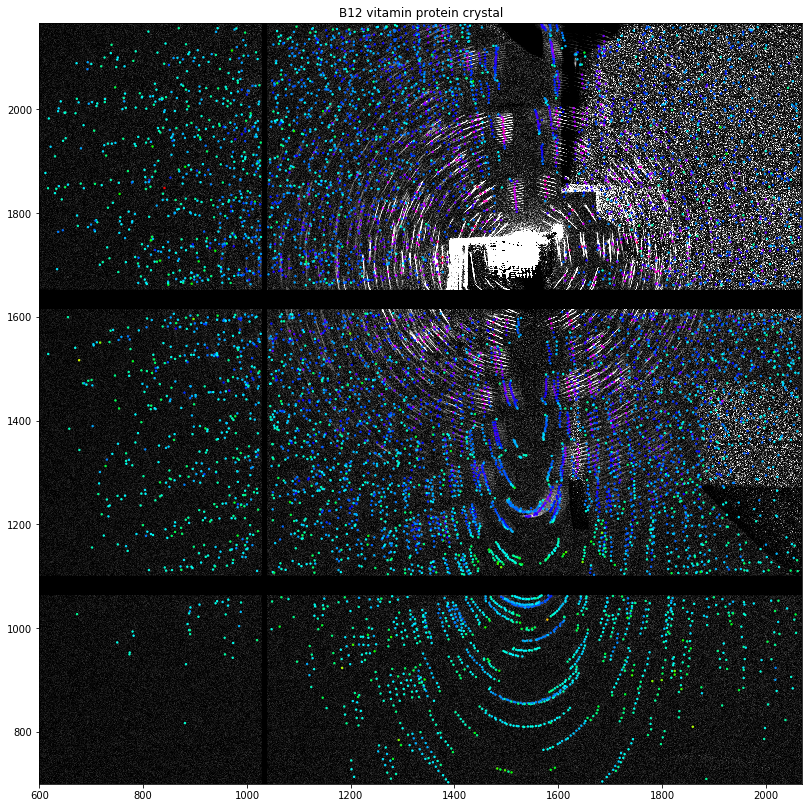

In [32]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(b12data.sum(axis=0), vmin=0, vmax=3000, cmap='gist_gray')
plt.scatter(b12sum[:, 0], b12sum[:, 1], s=2, c=np.log(b12sumints - b12sumints.min() + 1.0), cmap='hsv')
plt.xlim((b12roi.roi[2], b12roi.roi[3]))
plt.ylim((b12roi.roi[0], b12roi.roi[1]))
plt.title('B12 vitamin protein crystal')
plt.show()

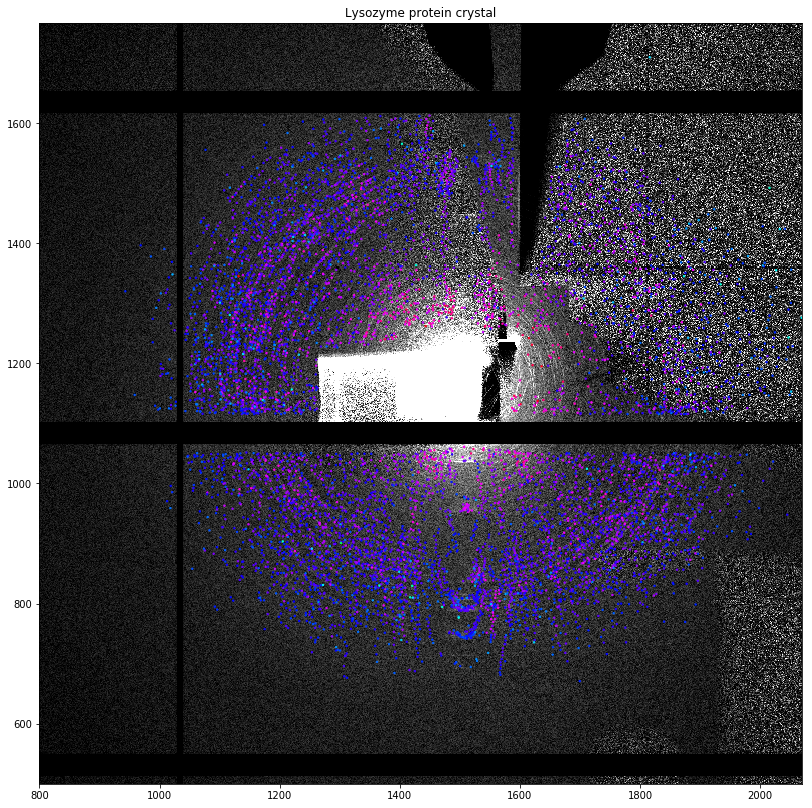

In [86]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(lysdata.sum(axis=0), vmin=100, vmax=3000, cmap='gist_gray')
plt.scatter(lyssum[:, 0], lyssum[:, 1], s=2, c=np.log(lyssumints - lyssumints.min() + 1.0), cmap='hsv')
plt.xlim((lysroi.roi[2], lysroi.roi[3]))
plt.ylim((lysroi.roi[0], lysroi.roi[1]))
plt.title('Lysozyme protein crystal')
plt.show()

# Diffraction simulation

In [16]:
datapath = 'results/diffracted lightwave values'
res = h5py.File(os.path.expanduser('~/OneDrive/programming/conv_beam/results/diff_22-08-2019_23-04-18.hdf5'), 'r')[datapath]
zero = np.array([1000, 1000])

In [63]:
frame = np.where(np.abs(res) < 0.05, 0, np.abs(res))
frame2 = np.clip(frame, 0, 0.16877577106960243)
nms1 = nms(frame)
thetas = np.linspace(-np.pi / 2, np.pi / 2, 10000, endpoint=True)
rawlns = np.array([[[x0, y0], [x1, y1]]
                  for (x0, y0), (x1, y1)
                  in probabilistic_hough_line(frame, threshold=10, line_length=30, line_gap=5, theta=thetas)])
rawlns2 = np.array([[[x0, y0], [x1, y1]]
                  for (x0, y0), (x1, y1)
                  in probabilistic_hough_line(nms1, threshold=10, line_length=30, line_gap=5, theta=thetas)])
img = np.tile((frame2 / frame2.max() * 255).astype(np.uint8)[..., np.newaxis], (1,1,3))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# lsd = cv2.createLineSegmentDetector(0)
# lns2 = lsd.detect(gray)[0][:, 0].reshape((-1, 2, 2))
# pts2 = framepoints(frame, lns2, zero)

In [62]:
np.mean(frame[frame != 0]) + np.std(frame[frame != 0])

0.16877577106960243

In [64]:
lnslist2 = []
lnslist2.append(findlines(rawlns, zero, 30, 10))
lnslist2.append(findlines(rawlns2, zero, 30, 10))
lnslist2.append(cv2.createLineSegmentDetector(0).detect(gray)[0][:, 0].reshape((-1, 2, 2)))
lnslist2.append(LSDlines(lnslist2[2], zero, drtau=20, drn=10))
ptslist2 = [framepoints(frame, lns, zero) for lns in lnslist2]

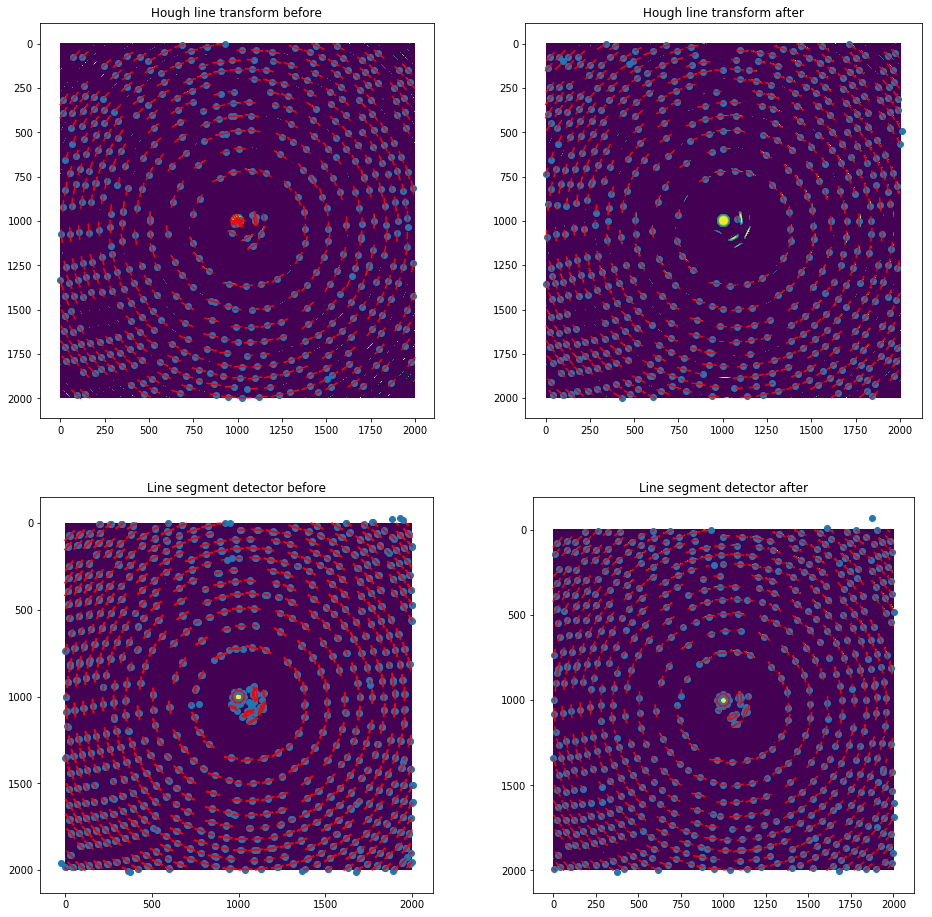

In [66]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
titles = ['Hough line transform before', 'Hough line transform after', 'Line segment detector before', 'Line segment detector after']
for ax, lines, pts, title in zip(axes.ravel(), lnslist2, ptslist2, titles):
    ax.imshow(frame, vmax=0.2)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'r')  
    ax.scatter(pts[:, 0], pts[:, 1])
#     ax.set_xlim(1400, 1900)
#     ax.set_ylim(1800, 1300)
    ax.set_title(title)
plt.show()

In [169]:
ptsc = lns.mean(axis=1)
ptsc2 = lns2.mean(axis=1)
var = ((pts - ptsc)**2).sum(axis=1).mean()
var2 = ((pts2 - ptsc2)**2).sum(axis=1).mean()
print(np.sqrt(var), np.sqrt(var2))

10.178557232916166 9.951110357738669


In [54]:
img = np.tile((nms2 / nms2.max() * 255).astype(np.uint8)[..., np.newaxis], (1,1,3))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lsd = cv2.createLineSegmentDetector(0)
lns3 = lsd.detect(gray)[0][:, 0].reshape((-1, 2, 2))
pts3 = framepoints(frame, lns3, zero)

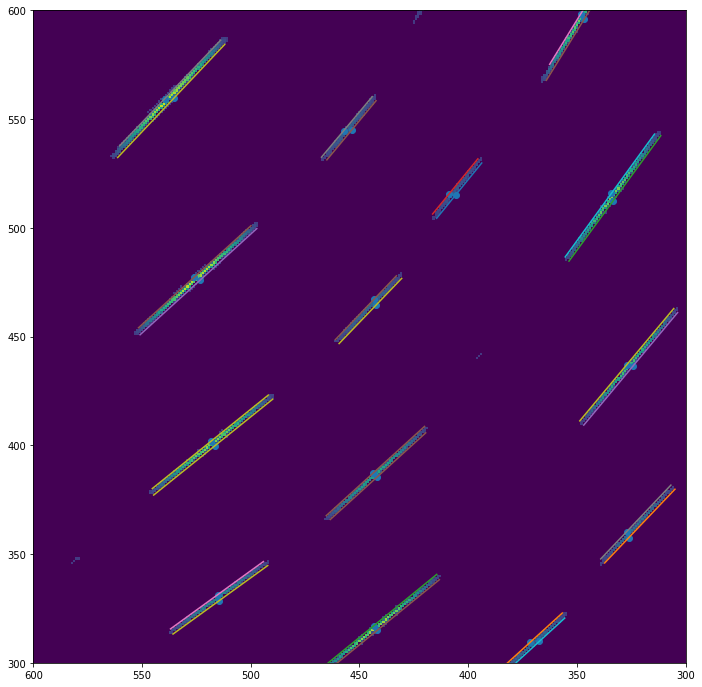

In [56]:
%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(12, 12))
axes.imshow((frame / frame.max() * 255).astype(np.uint8))
for line in lns3:
    axes.plot(line[:, 0], line[:, 1])
axes.scatter(pts3[:, 0], pts3[:, 1])
axes.set_xlim(600, 300)
axes.set_ylim(300, 600)
plt.show()

In [240]:
class Detector(object):
    def __init__(self, detdist=54, Nx=512, Ny=512, pixsize=55e-3):
        self.detdist, self.Nx, self.Ny, self.pixsize = detdist, Nx, Ny, pixsize

    def det_coordinates(self):
        x_det = np.arange((-self.Nx + 1) / 2.0, (self.Nx + 1) / 2.0) * self.pixsize
        y_det = np.arange((-self.Ny + 1) / 2.0, (self.Ny + 1) / 2.0) * self.pixsize
        xs, ys = np.meshgrid(x_det, y_det)
        return xs, ys

    def kouts2(self):
        xs, ys = self.det_coordinates()
        kxs = np.tan(np.sqrt(xs**2 + ys**2) / self.detdist) * np.cos(np.arctan2(ys, xs))
        kys = np.tan(np.sqrt(xs**2 + ys**2) / self.detdist) * np.sin(np.arctan2(ys, xs))
        return np.stack((kxs, kys, np.sqrt(1 - kxs**2 - kys**2)), axis=2)
    
    def kouts(self):
        xs, ys = self.det_coordinates()
        return np.stack((xs / self.detdist, ys / self.detdist, 1 - (xs**2 + ys**2) / 2 / self.detdist**2), axis=2)

In [242]:
kouts = Detector(detdist, 2000, 2000, pixsize).kouts()
kouts2 = Detector(detdist, 2000, 2000, pixsize).kouts2()
idxs = lns.mean(axis=1).astype(np.int)
idxs2 = lns2.mean(axis=1).astype(np.int)
ks, ks2 = kouts[idxs[:,0], idxs[:,1]], kouts2[idxs2[:,0], idxs2[:,1]]

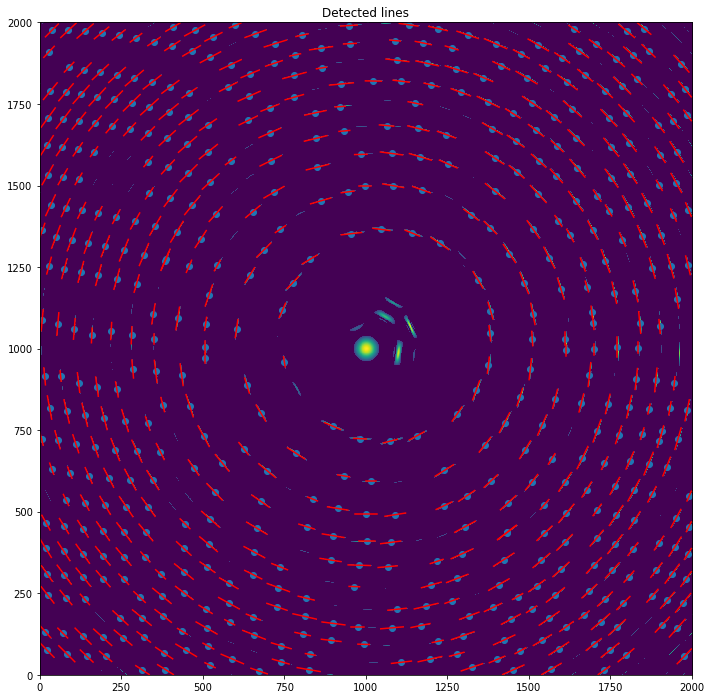

In [83]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.imshow(frame)
plt.scatter(lns.mean(axis=1)[:,0], lns.mean(axis=1)[:,1])
plt.title('Detected lines')
for line in lns:
    plt.plot(line[:,0], line[:,1], 'r')
plt.xlim(0, frame.shape[1])
plt.ylim(0, frame.shape[0])
plt.show()

In [14]:
datapath2 = 'data/data'
res2 = h5py.File('/Users/simply_nicky/OneDrive/programming/conv_beam/results/diff_07-09-2019_05-32-33.hdf5', 'r')[datapath2]
thetas = np.linspace(-np.pi / 2, np.pi / 2, 10000, endpoint=True)
frame2 = np.where(np.abs(res2) < 0.05, 0, np.abs(res2))
nms2 = nms(frame2)
rawlns2 = np.array([[[x0, y0], [x1, y1]]
                  for (x0, y0), (x1, y1)
                  in probabilistic_hough_line(nms2, threshold=10, line_length=30, line_gap=5, theta=thetas)])
lns2 = findlines(rawlns2, zero, 30, 10)

[autoreload of p06_dp.wrapper failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 277, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


NameError: name 'res2' is not defined

In [177]:
detdist = 250
pixsize = 88.6e-3
yarpts = np.loadtxt("/Users/simply_nicky/OneDrive/programming/conv_beam/results/peaksOnDetector_px.txt") * pixsize
xyar, yyar = yarpts[:,0], -yarpts[:,1]
x2, y2 = pixsize * (lns2.mean(axis=1) - zero)[:,0], pixsize * (lns2.mean(axis=1) - zero)[:,1]
kxyar = np.arctan(np.sqrt(xyar**2 + yyar**2) / detdist) * np.cos(np.arctan2(yyar, xyar))
kyyar = np.arctan(np.sqrt(xyar**2 + yyar**2) / detdist) * np.sin(np.arctan2(yyar, xyar))
kx2 = np.arctan(np.sqrt(x2**2 + y2**2) / detdist) * np.cos(np.arctan2(y2, x2))
ky2 = np.arctan(np.sqrt(x2**2 + y2**2) / detdist) * np.sin(np.arctan2(y2, x2))

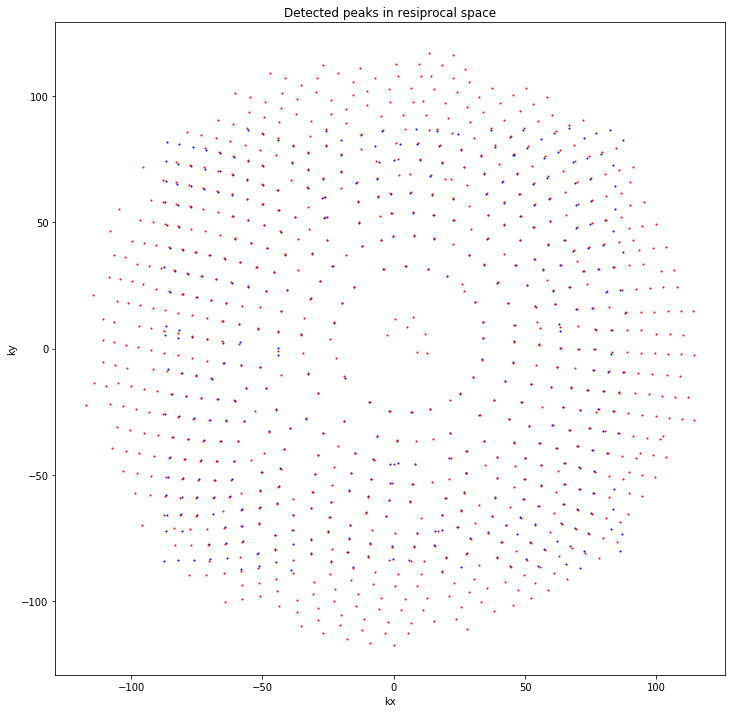

In [178]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.scatter(x2, y2, 1, 'b')
plt.scatter(xyar, yyar, 1, 'r')
plt.title('Detected peaks in resiprocal space')
plt.xlabel('kx')
plt.ylabel('ky')
plt.show()

In [37]:
res = np.load(os.path.expanduser('~/OneDrive/programming/conv_beam/results/temp4.npy'))
frame = np.abs(res)
yarpts = np.loadtxt(os.path.expanduser("~/OneDrive/programming/conv_beam/results/peaksOnDetector_px.txt"))
xyar, yyar = yarpts[:,0], -yarpts[:,1]

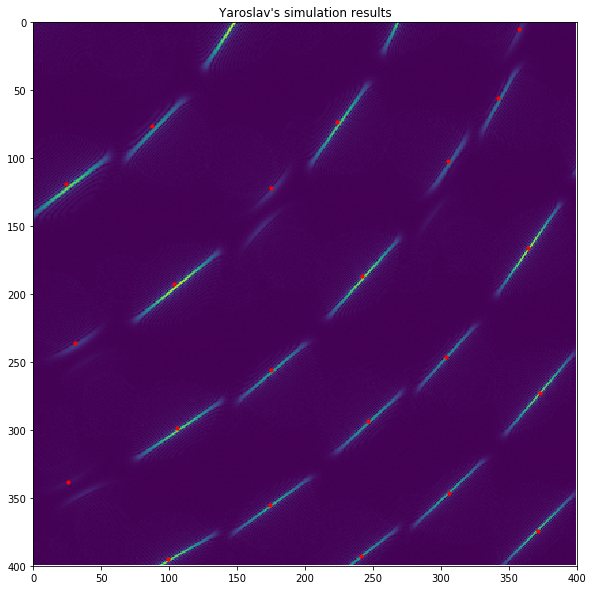

In [38]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.scatter(xyar - 300, yyar - 300, 10, 'r')
plt.ylim(400, 0)
plt.xlim(0, 400)
plt.title("Yaroslav's simulation results")
plt.show()